<a href="https://colab.research.google.com/github/N1a2t3a/.Data_Science/blob/main/OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [5]:
df = pd.read_csv('bikes_rent.csv')

print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

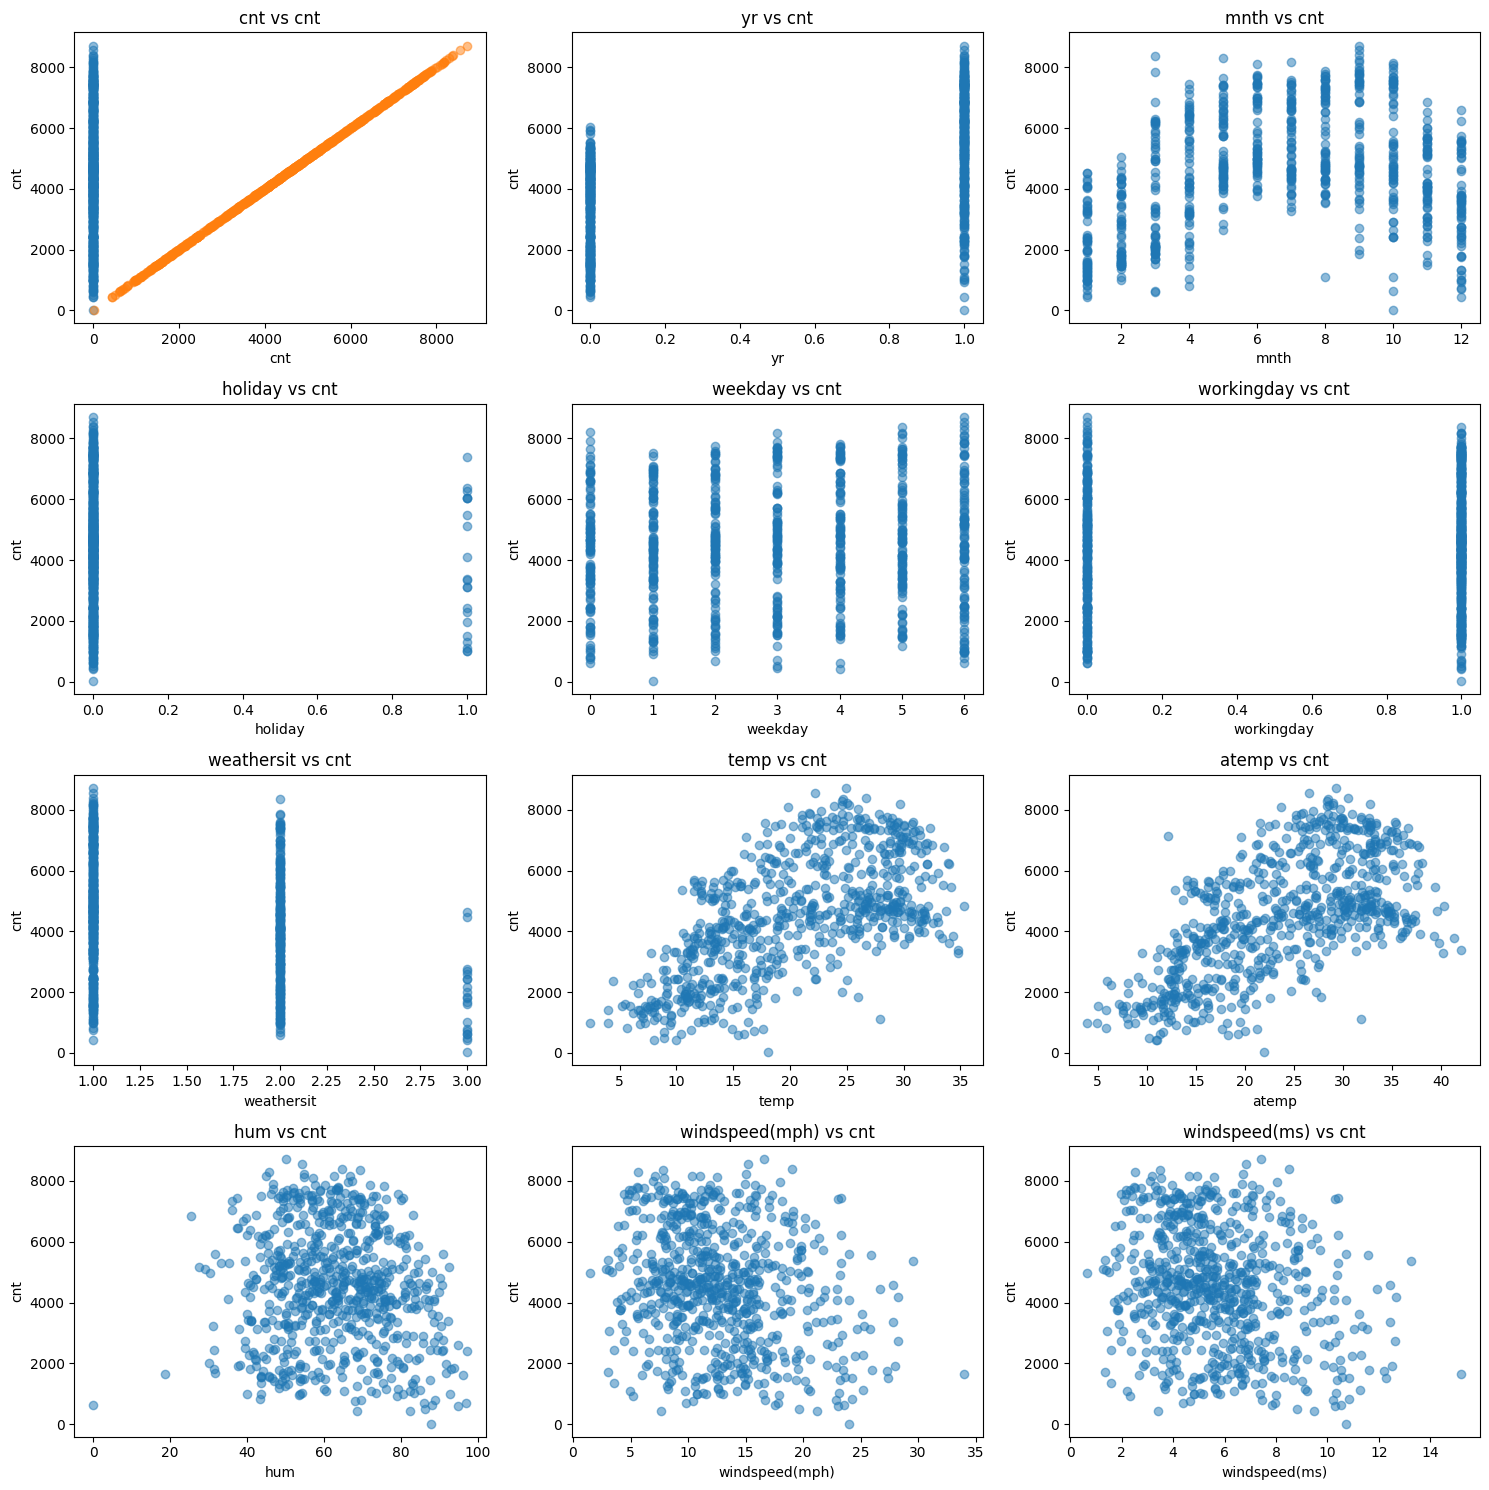

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()

target_attribute = 'cnt'

for i, column in enumerate(df.columns):
    ax = axes[i % 12]
    ax.scatter(df[column], df[target_attribute], alpha=0.5)
    ax.set_title(f'{column} vs {target_attribute}')
    ax.set_xlabel(column)
    ax.set_ylabel(target_attribute)

plt.tight_layout()
plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца? Відповідь: Характер залежності числа прокатів від місяця не виглядає лінійним на графіку. Немає чіткої прямої тенденції або стрілки, яка вказувала б на лінійну залежність між місяцем і кількістю прокатів.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно. Відповідь: можна розглянути коефіцієнти кореляції між числом прокатів (cnt) та іншими числовими признаками, такими як температура (temp), температура по відчуттях (atemp), вологість (hum), і інші.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [9]:
features = df.iloc[:, :-1]

target = df['cnt']

correlations = features.corrwith(target)

print(correlations)


numeric_features = df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]

numeric_correlations = numeric_features.corr()

print(numeric_correlations)



season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64
                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [10]:
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]

correlations_matrix = selected_features.corr()

print(correlations_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [11]:
mean_values = df.mean()

print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [13]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [14]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [15]:
from sklearn.linear_model import LinearRegression

X = df.iloc[:, :-1]
y = df['cnt']

model = LinearRegression()
model.fit(X, y)

weights = list(zip(df.columns[:-1], model.coef_))

for feature, weight in weights:
    print(f'{feature}: {weight}')


season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [17]:
from sklearn.linear_model import Lasso

X = df.iloc[:, :-1]
y = df['cnt']

lasso_model = Lasso()
lasso_model.fit(X, y)

lasso_weights = list(zip(df.columns[:-1], lasso_model.coef_))

print("Weights for Lasso:")
for feature, weight in lasso_weights:
    print(f'{feature}: {weight}')


Weights for Lasso:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [18]:
from sklearn.linear_model import Ridge

X = df.iloc[:, :-1]
y = df['cnt']

ridge_model = Ridge()
ridge_model.fit(X, y)

ridge_weights = list(zip(df.columns[:-1], ridge_model.coef_))

print("\nWeights for Ridge:")
for feature, weight in ridge_weights:
    print(f'{feature}: {weight}')



Weights for Ridge:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [20]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Lasso Coefficients:")
for alpha, coef in zip(alphas, coefs_lasso):
    print(f'Alpha = {alpha}: {coef}')

print("\nRidge Coefficients:")
for alpha, coef in zip(alphas, coefs_ridge):
    print(f'Alpha = {alpha}: {coef}')


Lasso Coefficients:
Alpha = 1: [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
  118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
  -38.34106761   -0.        ]
Alpha = 51: [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
    0.         -291.33521188   44.34993053   83.88557181  -18.81320743
  -43.35682101   -0.        ]
Alpha = 101: [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
    0.           -0.           37.46764176   95.93389064  -26.48659474
  -48.19495616   -0.        ]
Alpha = 151: [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
    0.           -0.           33.15169023  102.54337981  -26.88669007
  -47.85305889   -0.        ]
Alpha = 201: [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
    0.           -0.           27.55035178  110.33369233  -27.29091458
  -47.46769509   -0.        ]
Alpha = 251: [  0.         994.19323854  73.37527257  -0.   

Проанализируйте динамику весов при увеличении параметра регуляризации:

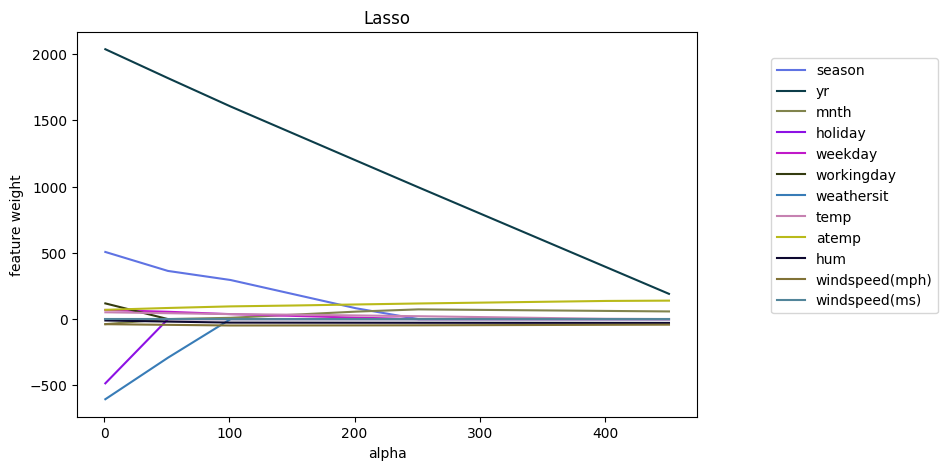

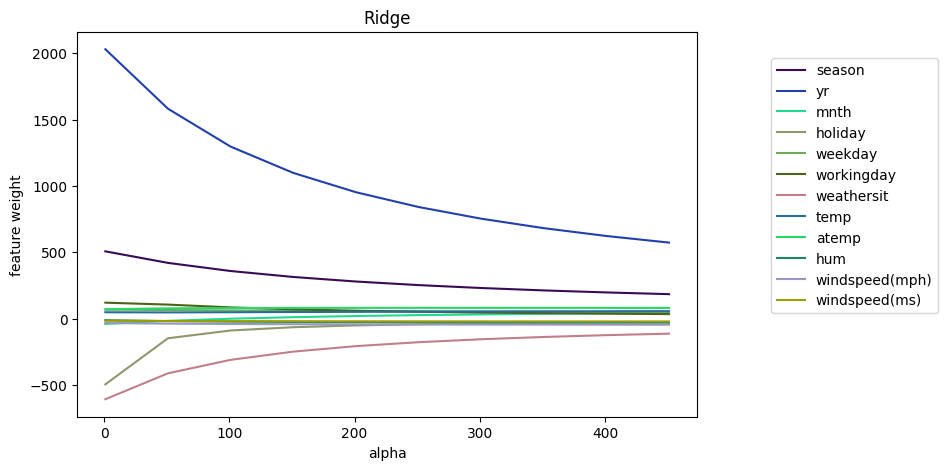

In [21]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
Відповідь: Lasso агрессивнее уменьшает веса при одном и том же alpha, так як він включає до свого функціоналу L1-регуляризацію, що може призводити до обнулення ваг для деяких ознак.

1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
 Відповідь: Якщо зробити alpha дуже великим, то всі ваги Lasso будуть рівні нулю або дуже близькі до нуля. Це відбувається через те, що велике значення alpha значно підсилює штраф за великі ваги у функціоналі втрат Lasso, що призводить до обнулення ваг для багатьох ознак.

1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
Відповідь: Так, Lasso при будь-якому значенні alpha > 0 може обнулити один із признаків windspeed, оскільки вона використовує L1-регуляризацію, яка спричинює обнулення деяких ваг. У Ridge ваги можуть стають меншими, але не обнулюються так агресивно, як у Lasso.

1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
Відповідь: Lasso більш підходить для відбору неінформативних признаків через його здатність до обнулення ваг для деяких ознак.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [22]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [26]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas)
regressor.fit(X, y)

selected_alpha = regressor.alpha_
print(f"Alpha = {selected_alpha}")

coefficients = regressor.coef_
feature_coef_pairs = list(zip(df.columns, coefficients))

for feature, coef in feature_coef_pairs:
    print(f"{feature}: {coef}")


Alpha = 1
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alpha = 1
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0
Shape of mse_path: (20, 5)
Number of folds (cv): 5


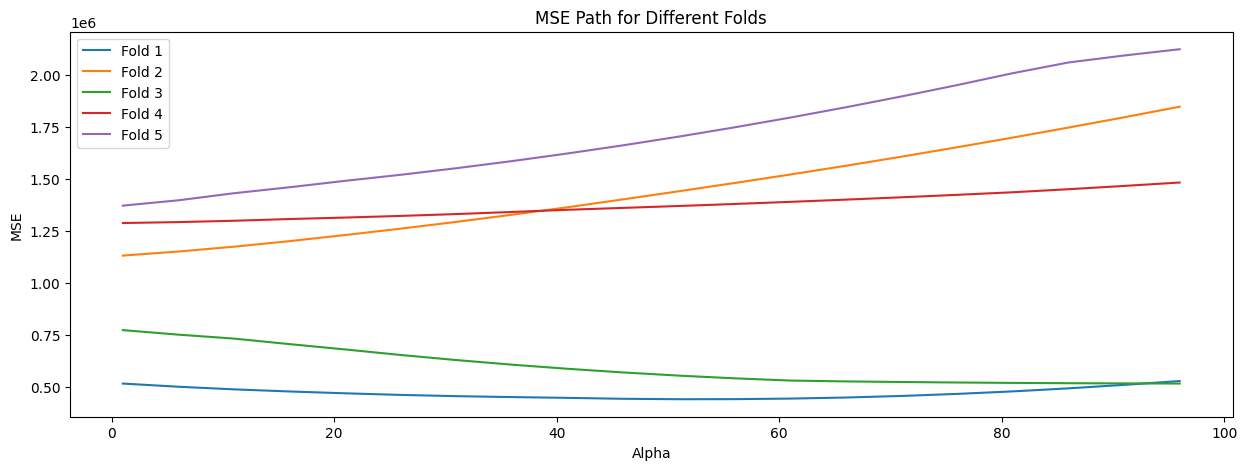

In [27]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5)
regressor.fit(X, y)

selected_alpha = regressor.alpha_
print(f"Alpha = {selected_alpha}")

coefficients = regressor.coef_
feature_coef_pairs = list(zip(df.columns, coefficients))

for feature, coef in feature_coef_pairs:
    print(f"{feature}: {coef}")

print("Shape of mse_path:", regressor.mse_path_.shape)
print("Number of folds (cv):", regressor.cv)

plt.figure(figsize=(15, 5))
for i in range(regressor.cv):
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f"Fold {i + 1}")

plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.title("MSE Path for Different Folds")
plt.legend()
plt.show()


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

Оберіть 4 признаки з найбільшими (позитивними) коефіцієнтами.
Відповідь: yr, atemp, season, temp
Визначте, чи є видима зростаюча лінійна залежність між cnt і цими признаками.
Відповідь: Так, графіки вже були наведені, і вони показують зростаючу лінійну залежність між кількістю прокатів та роком, температурою та сезоном.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

Оберіть 3 признаки з найбільшими за модулем від'ємними коефіцієнтами.
Відповідь: weathersit, windspeed(mph), hum

Визначте, чи є видима зменшуюча лінійна залежність між cnt і цими признаками.
Відповідь: Так, графіки вже були наведені, і вони показують зменшуючу лінійну залежність між кількістю прокатів та станом погоди, швидкістю вітру та вологістю.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

Виведіть признаки з коефіцієнтами, близькими до нуля (< 1e-3).
Відповідь: windspeed(ms)

Розгляньте, чому модель виключила їх з розрахунку (визначте, чи вони дійсно не впливають на споживання велосипедів).
Відповідь: windspeed(ms) є лінійною функцією windspeed(mph). Таким чином, цей признак є зайвим, і модель виключила його.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.